In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import r2_score

import numpy as np

from tqdm import tqdm
from datetime import timedelta  

import warnings
warnings.filterwarnings(action='ignore')

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [56]:
def plot_line(df, title):
    fig = px.line(df, x = 'date', y = 'count', title = title)
    fig.show()
    
def filter_column(df, column, border_low, border_high):
    filter_mask = (df[column] >= border_low) & (df[column] < border_high)
    
    filtered_df = df[filter_mask].reset_index(drop=True)
    return filtered_df

def convert_columns(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

def plot_prediction(total, pred, test, title):
    r2 = r2_score(test, pred)
    predict_index = list(pred.index)

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(total);

    ax.vlines(test.index[0], 0, 100000, linestyle='--', color = 'r', label ='Start of Forecast')
    ax.plot(predict_index, pred.values, label = 'Prediction')

    # ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

    ax.legend(loc = 'upper left')

    plt.suptitle(f'{title} Prediction Results (r2_score: {round(r2, 2)})')
    plt.show()

In [57]:
train_data = pd.read_csv("../dataset/train_test/train.csv")
test_data = pd.read_csv("../dataset/train_test/test.csv")

train_data = train_data[['date', 'count']]
test_data = test_data[['date', 'count']]

data = pd.concat([train_data, test_data])

data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

In [58]:
lstm_plot = pd.read_csv("../dataset/results/lstm/lstm_plot.csv")

lstm_plot = lstm_plot[['date', 'predict']]
lstm_plot = convert_columns(lstm_plot)

lstm_plot = lstm_plot[lstm_plot.index >= '2020-03-01']

In [64]:
svr_plot = pd.read_csv("../dataset/results/svr/svr_summary.csv")

svr_plot = svr_plot[['date', 'predict']]
svr_plot = convert_columns(svr_plot)

svr_plot = svr_plot[svr_plot.index >= '2020-03-01']

In [71]:
old_plot = pd.read_excel("../dataset/results/residuals/old_summary.xlsx")

old_plot = convert_columns(old_plot)
old_plot = old_plot[old_plot.index >= '2020-03-01']

In [96]:
old_plot

,trigonometric,구간평균법,simple exponential smoothing,double exponential smoothing,additive holt winters,multiplicative holt winters,linear
date,,,,,,,
2020-03-01,57974.831646,27715.8,24431.000000,48851.000000,26666.916831,-777.087876,15350
2020-03-02,58518.935867,27715.8,35420.000000,51751.040000,26675.353480,-599.789238,15350
2020-03-03,57255.273454,27715.8,39044.300000,42837.460400,26466.121017,-624.553915,15350
2020-03-04,57799.377674,27715.8,32046.530000,45441.121004,27259.034983,282.849182,15350
2020-03-05,58343.481895,27715.8,35470.553000,49833.916174,28195.543442,1324.693902,15350
...,...,...,...,...,...,...,...
2020-06-26,63786.493173,27715.8,90992.864159,107094.369888,10289.923545,4749.422671,46017
2020-06-27,64330.597393,27715.8,105400.186416,100377.849804,11225.147512,5805.991924,46017
2020-06-28,64874.701613,27715.8,99251.218642,71313.461313,9531.890064,4409.197293,46017


In [85]:
test_data

,count
date,
2020-03-01,24431
2020-03-02,36641
2020-03-03,39447
2020-03-04,31269
2020-03-05,35851
...,...
2020-06-26,96150
2020-06-27,107001
2020-06-28,98568


In [88]:
r2_score(average_mean, test_data)

-2.272066926348254e+31

In [75]:
average_mean = old_plot['구간평균법']
trigonometric = old_plot['trigonometric']
simple_exp = old_plot['simple exponential smoothing']
double_exp = old_plot['double exponential smoothing']
additive_holt = old_plot['additive holt winters']
multiple_holt = old_plot['multiplicative holt winters']
linear = old_plot['linear']

In [81]:
model_list = [
    (average_mean, "interval_mean"),
    (trigonometric, 'trigonometric'),
    (simple_exp,'simple exponential smoothing'),
    (double_exp,'double exponential smoothing'),
    (additive_holt,'additive holt winters'),
    (multiple_holt,'multiplicative holt winters'),
    (linear,'linear')
]

In [83]:
simple_exp

date
2020-03-01     24431.000000
2020-03-02     35420.000000
2020-03-03     39044.300000
2020-03-04     32046.530000
2020-03-05     35470.553000
                  ...      
2020-06-26     90992.864159
2020-06-27    105400.186416
2020-06-28     99251.218642
2020-06-29     72972.821864
2020-06-30     41574.682186
Name: simple exponential smoothing, Length: 122, dtype: float64

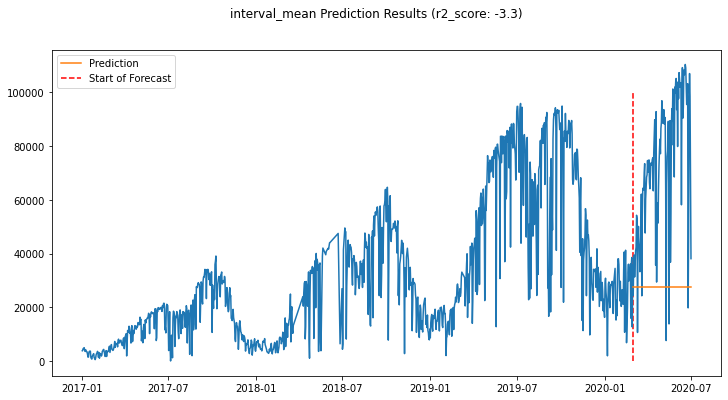

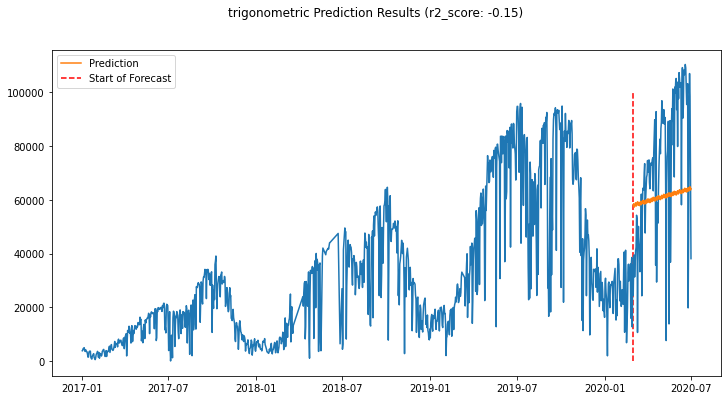

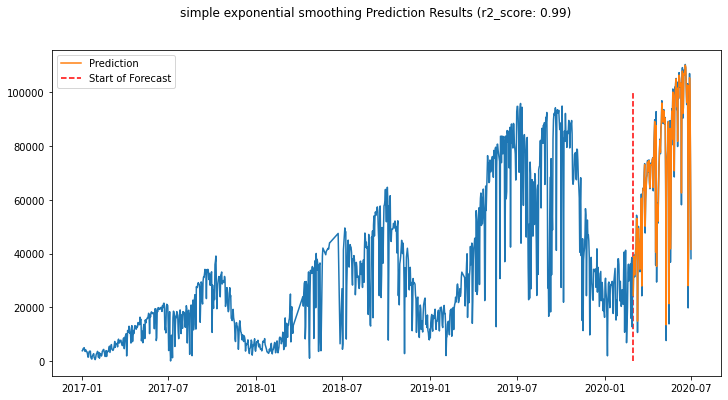

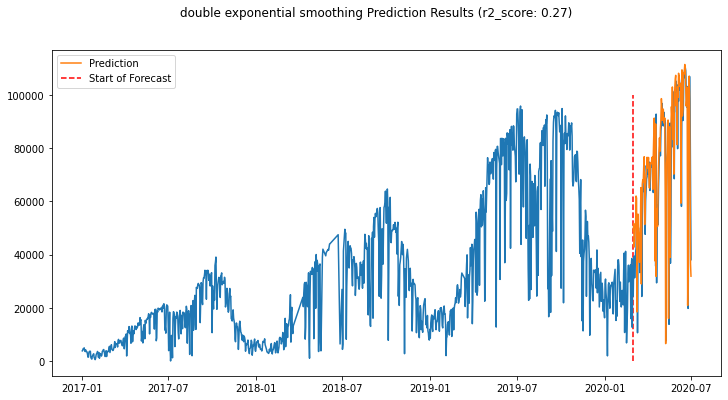

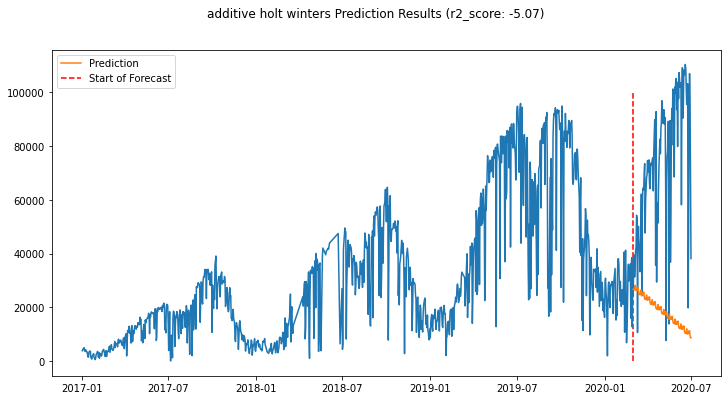

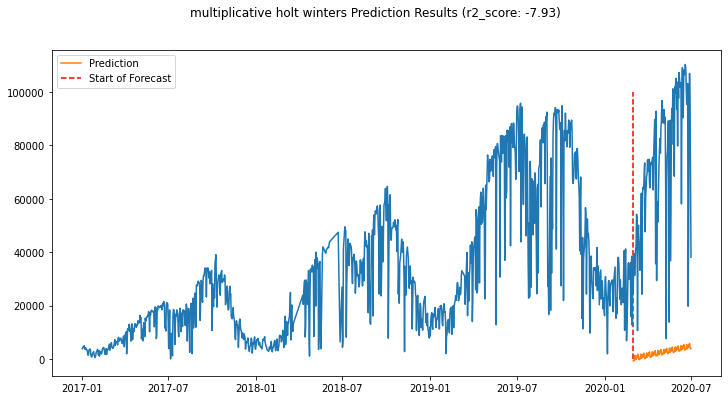

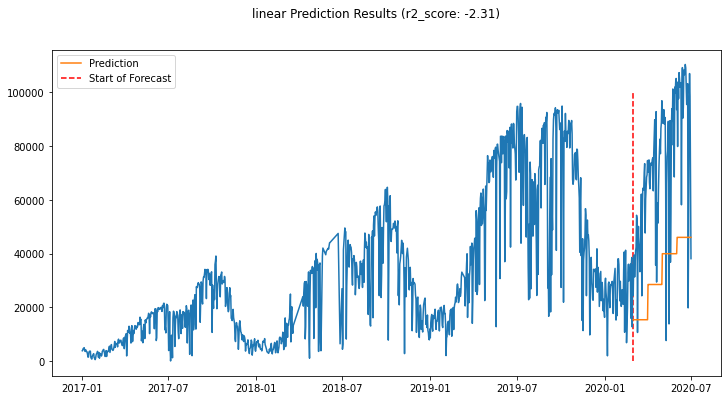

In [82]:
for model in model_list:
    plot_prediction(data, model[0],  test_data, model[1])

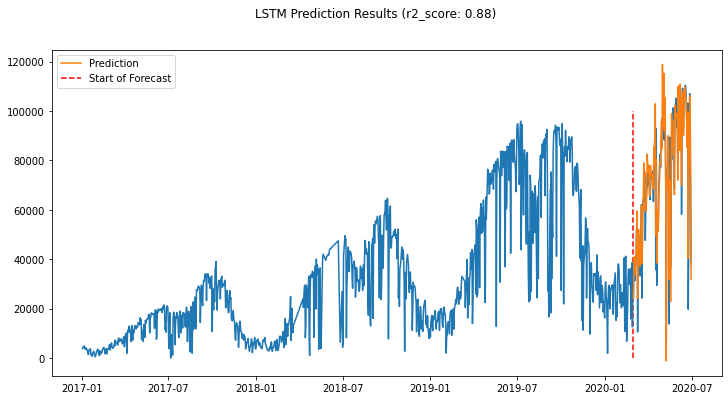

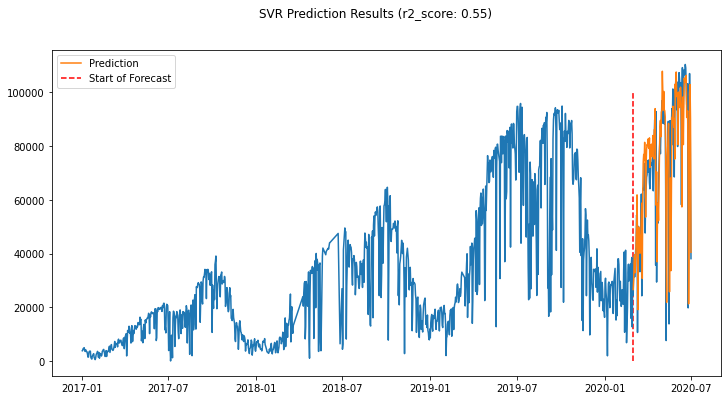

In [67]:
plot_prediction(data, lstm_plot, test_data, 'LSTM')
plot_prediction(data, svr_plot, test_data, 'SVR')

In [92]:
lstm_result = pd.read_csv('../dataset/results/lstm/lstm_result.csv')
svr_result = pd.read_csv('../dataset/results/svr/svr_result.csv')
old_result = pd.read_excel('../dataset/results/residuals/old_result.xlsx')

In [93]:
lstm_result

,date,learning_rate,window_size,mse,mae,mape,smape
0,12-1 14:34,0.001,3,75437100.0,6376.3076,12.594271,11.821646


In [94]:
old_result

,Unnamed: 0,trigonometric,구간평균법(5),simple exponential smoothing,double exponential smoothing,additive Holt-Winters,Multiplicative Holt-Winters,linear
0,AIC,2.491213e+03,2.651701e+03,1.873908e+03,2.434523e+03,2.693722e+03,2.740769e+03,2.619560e+03
1,r_square,-1.549600e-01,-3.304030e+00,9.926700e-01,2.742900e-01,-5.073760e+00,-7.931760e+00,-2.307170e+00
2,mae,2.317342e+04,4.665994e+04,1.365331e+03,1.408642e+04,5.527890e+04,7.091069e+04,4.258266e+04
3,mape,4.427002e+01,6.139983e+01,3.715050e+00,3.261720e+01,7.077704e+01,9.636145e+01,6.107573e+01
4,smape,3.519411e+01,8.600544e+01,3.298050e+00,2.495536e+01,1.123023e+02,1.862649e+02,8.122070e+01
5,mse,7.262351e+08,2.706350e+09,4.608952e+06,4.563238e+08,3.819150e+09,5.616240e+09,2.079528e+09


In [95]:
svr_result

,date,mse,mae,mape,smape
0,12-1 14:1,2.842415e+08,11750.335303,28.167379,20.598302
